# Temperature Prediction Model

## Introduction

In this notebook we will be going through an end-to-end project to load in weather data from [Data Asset eXchange](https://developer.ibm.com/exchanges/data/all/jfk-weather-data/), prepare the data into a wide format, build some machine learning models, and then deploy those built models. 

# Import Required Packages

In [ ]:
# Install Packages
!pip install pandas seaborn scikit-learn statsmodels==0.11.1 --user

In [1]:
# Import required packages
import pandas as pd

# These set pandas max column and row display in the notebook
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import numpy as np
import sys
import re
import itertools
import os
import tarfile
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 160
import seaborn as sns

# Model development
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults

import warnings
warnings.filterwarnings('ignore')

# Read Data

The NOAA JFK dataset contains 114,546 hourly observations of various local climatological variables (including visibility, temperature, wind speed and direction, humidity, dew point, and pressure). The data was collected by a NOAA weather station located at the John F. Kennedy International Airport in Queens, New York.

In [3]:
fname = os.getenv("DATA_DIR", "data-vol-1") + '/noaa-weather-data-jfk-airport.tar.gz'

In [4]:
# Extracting the dataset
tar = tarfile.open(fname)
tar.extractall()
tar.close()

In [5]:
# Set the data path
data_path = 'noaa-weather-data-jfk-airport/jfk_weather.csv'

In [6]:
# Display first five rows of the data
raw_data = pd.read_csv(data_path, parse_dates=['DATE'])
raw_data.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,HOURLYDRYBULBTEMPF,HOURLYDRYBULBTEMPC,HOURLYWETBULBTEMPF,HOURLYWETBULBTEMPC,HOURLYDewPointTempF,HOURLYDewPointTempC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYWindGustSpeed,HOURLYStationPressure,HOURLYPressureTendency,HOURLYPressureChange,HOURLYSeaLevelPressure,HOURLYPrecip,...,MonthlyGreatestPrecip,MonthlyGreatestPrecipDate,MonthlyGreatestSnowfall,MonthlyGreatestSnowfallDate,MonthlyGreatestSnowDepth,MonthlyGreatestSnowDepthDate,MonthlyDaysWithGT90Temp,MonthlyDaysWithLT32Temp,MonthlyDaysWithGT32Temp,MonthlyDaysWithLT0Temp,MonthlyDaysWithGT001Precip,MonthlyDaysWithGT010Precip,MonthlyDaysWithGT1Snow,MonthlyMaxSeaLevelPressureValue,MonthlyMaxSeaLevelPressureDate,MonthlyMaxSeaLevelPressureTime,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureDate,MonthlyMinSeaLevelPressureTime,MonthlyTotalHeatingDegreeDays,MonthlyTotalCoolingDegreeDays,MonthlyDeptFromNormalHeatingDD,MonthlyDeptFromNormalCoolingDD,MonthlyTotalSeasonToDateHeatingDD,MonthlyTotalSeasonToDateCoolingDD
0,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 00:51:00,FM-15,FEW:02 7 SCT:04 13 BKN:07 29,6.00,-RA:02 PL:06 BR:1 |RA:61 PL:74 |RA:61 PL:79,33,0.6,32,0.1,31,-0.6,92,0,000,NaN,29.97,8.0,NaN,29.99,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
1,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 01:00:00,FM-12,NaN,5.59,||PL:79,33,0.6,32,0.1,31,-0.6,92,0,000,NaN,29.96,8.0,+0.05,29.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
2,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 01:51:00,FM-15,FEW:02 6 SCT:04 13 OVC:08 35,6.00,-RA:02 PL:06 BR:1 |RA:61 PL:74 |RA:61 PL:79,33,0.6,33,0.3,32,0.0,96,0,000,NaN,29.97,NaN,NaN,29.99,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
3,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 02:03:00,FM-16,FEW:02 6 SCT:04 13 OVC:08 35,6.00,-RA:02 BR:1 |RA:61 |RA:61,34,1,33,0.7,32,0.0,93,0,000,NaN,29.97,NaN,NaN,NaN,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
4,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 02:28:00,FM-16,BKN:07 7 BKN:07 15 OVC:08 35,5.00,-RA:02 BR:1 |RA:61 |RA:61,34,1,33,0.7,32,0.0,93,0,000,NaN,29.97,NaN,NaN,NaN,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Data type of the attribute
raw_data.dtypes

STATION                               object
STATION_NAME                          object
ELEVATION                            float64
LATITUDE                             float64
LONGITUDE                            float64
                                      ...   
MonthlyTotalCoolingDegreeDays         object
MonthlyDeptFromNormalHeatingDD        object
MonthlyDeptFromNormalCoolingDD        object
MonthlyTotalSeasonToDateHeatingDD    float64
MonthlyTotalSeasonToDateCoolingDD    float64
Length: 90, dtype: object

#### OBSERVATION

As you can see above, there are a lot of fields which are non-numerical - usually these will be fields that contain text or categorical data, e.g. HOURLYSKYCONDITIONS.

There are also fields - such as the main temperature field of interest HOURLYDRYBULBTEMPF - that we expect to be numerical, but are instead object type. This often indicates that there may be missing (or null) values, or some other unusual readings that we may have to deal with (since otherwise the field would have been fully parsed as a numerical data type).

In addition, some fields relate to hourly observations, while others relate to daily or monthly intervals. For purposes of later exploratory data analysis, we will restrict the dataset to a certain subset of numerical fields that relate to hourly observations.

In this section, we refer to the [NOAA Local Climatological Data Documentation](https://data.noaa.gov/dataset/dataset/u-s-local-climatological-data-lcd/resource/ee7381ea-647a-434f-8cfa-81202b9b4c05) to describe the fields and meaning of various values.

# DATA CLEANING

In [8]:
def tryconvert(value, dt=None):
    """
    value -> Value to be converted
    dt    -> data type to convert to (redundant for now)
    """
    try:
        return np.float64(value)
    except:
        return np.nan

def clean_data(data_path):
   
    
    import_columns = [  'DATE',
                        'HOURLYVISIBILITY',
                        'HOURLYDRYBULBTEMPF',
                        'HOURLYWETBULBTEMPF',
                        'HOURLYDewPointTempF',
                        'HOURLYRelativeHumidity',
                        'HOURLYWindSpeed',
                        'HOURLYWindDirection',
                        'HOURLYStationPressure',
                        'HOURLYPressureTendency',
                        'HOURLYSeaLevelPressure',
                        'HOURLYPrecip',
                        'HOURLYAltimeterSetting']
    
    # Read data and set datetime index
    data_weather = pd.read_csv(data_path, parse_dates=['DATE'], usecols=import_columns)
    data_weather = data_weather.set_index(pd.DatetimeIndex(data_weather['DATE']))
    data_weather.drop(['DATE'], axis=1, inplace=True)
    
    # Replace '*' values with np.nan
    data_weather.replace(to_replace='*', value=np.nan, inplace=True)
    # Replace trace amounts of precipitation with 0
    data_weather['HOURLYPrecip'].replace(to_replace='T', value='0.00', inplace=True) 
    # Replace rows with tow '.' with np.nan
    data_weather.loc[data_weather['HOURLYPrecip'].str.count('\.') > 1, 'HOURLYPrecip'] = np.nan 

    # Convert to float
    for i, _ in enumerate(data_weather.columns):
        data_weather.iloc[:,i] =  data_weather.iloc[:,i].apply(lambda x: tryconvert(x))

    # Replace any hourly visibility figure outside these 0-10 bounds
    data_weather.loc[(data_weather['HOURLYVISIBILITY'] > 10) | (data_weather['HOURLYVISIBILITY'] < 0), 'HOURLYVISIBILITY'] = np.nan

    # Downsample to hourly rows 
    data_weather = data_weather.resample('60min').last().shift(periods=1) 

    # Interpolate missing values
    data_weather['HOURLYPressureTendency'] = data_weather['HOURLYPressureTendency'].fillna(method='ffill') #fill with last valid observation
    data_weather = data_weather.interpolate(method='linear')
    data_weather.drop(data_weather.index[0], inplace=True) #drop first row

    # Transform HOURLYWindDirection into a cyclical variable using sin and cos transforms
    data_weather['HOURLYWindDirectionSin'] = np.sin(data_weather['HOURLYWindDirection']*(2.*np.pi/360))
    data_weather['HOURLYWindDirectionCos'] = np.cos(data_weather['HOURLYWindDirection']*(2.*np.pi/360))
    data_weather.drop(['HOURLYWindDirection'], axis=1, inplace=True)

    # Transform HOURLYPressureTendency into 3 dummy variables based on NOAA documentation
    data_weather['HOURLYPressureTendencyIncr'] = [1.0 if x in [0,1,2,3] else 0.0 for x in data_weather['HOURLYPressureTendency']] # 0 through 3 indicates an increase in pressure over previous 3 hours
    data_weather['HOURLYPressureTendencyDecr'] = [1.0 if x in [5,6,7,8] else 0.0 for x in data_weather['HOURLYPressureTendency']] # 5 through 8 indicates a decrease over the previous 3 hours
    data_weather['HOURLYPressureTendencyCons'] = [1.0 if x == 4 else 0.0 for x in data_weather['HOURLYPressureTendency']] # 4 indicates no change during the previous 3 hours
    data_weather.drop(['HOURLYPressureTendency'], axis=1, inplace=True)
    data_weather['HOURLYPressureTendencyIncr'] = data_weather['HOURLYPressureTendencyIncr'].astype(('float32'))
    data_weather['HOURLYPressureTendencyDecr'] = data_weather['HOURLYPressureTendencyDecr'].astype(('float32'))
    data_weather['HOURLYPressureTendencyCons'] = data_weather['HOURLYPressureTendencyCons'].astype(('float32'))

 
    print("Data successfully cleaned, below are some stats:")
    print('# of megabytes held by dataframe: ' + str(round(sys.getsizeof(data_weather) / 1000000,2)))
    print('# of features: ' + str(data_weather.shape[1])) 
    print('# of observations: ' + str(data_weather.shape[0]))
    print('Start date: ' + str(data_weather.index[0]))
    print('End date: ' + str(data_weather.index[-1]))
    print('# of days: ' + str((data_weather.index[-1] - data_weather.index[0]).days))
    print('# of months: ' + str(round((data_weather.index[-1] - data_weather.index[0]).days/30,2)))
    print('# of years: ' + str(round((data_weather.index[-1] - data_weather.index[0]).days/365,2)))
        
    return data_weather

In [9]:
cleaned_hourly_data = clean_data(data_path)

Data successfully cleaned, below are some stats:
# of megabytes held by dataframe: 8.71
# of features: 15
# of observations: 75119
Start date: 2010-01-01 01:00:00
End date: 2018-07-27 23:00:00
# of days: 3129
# of months: 104.3
# of years: 8.57


In [10]:
cleaned_hourly_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75119 entries, 2010-01-01 01:00:00 to 2018-07-27 23:00:00
Freq: 60T
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   HOURLYVISIBILITY            75119 non-null  float64
 1   HOURLYDRYBULBTEMPF          75119 non-null  float64
 2   HOURLYWETBULBTEMPF          75119 non-null  float64
 3   HOURLYDewPointTempF         75119 non-null  float64
 4   HOURLYRelativeHumidity      75119 non-null  float64
 5   HOURLYWindSpeed             75119 non-null  float64
 6   HOURLYStationPressure       75119 non-null  float64
 7   HOURLYSeaLevelPressure      75119 non-null  float64
 8   HOURLYPrecip                75119 non-null  float64
 9   HOURLYAltimeterSetting      75119 non-null  float64
 10  HOURLYWindDirectionSin      75119 non-null  float64
 11  HOURLYWindDirectionCos      75119 non-null  float64
 12  HOURLYPressureTendencyIncr  75119 non-null 

In [11]:
cleaned_hourly_data.head()

,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYStationPressure,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting,HOURLYWindDirectionSin,HOURLYWindDirectionCos,HOURLYPressureTendencyIncr,HOURLYPressureTendencyDecr,HOURLYPressureTendencyCons
DATE,,,,,,,,,,,,,,,
2010-01-01 01:00:00,6.0,33.0,32.0,31.0,92.0,0.0,29.97,29.99,0.01,29.99,0.0,1.0,0.0,1.0,0.0
2010-01-01 02:00:00,6.0,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.02,29.99,0.0,1.0,0.0,1.0,0.0
2010-01-01 03:00:00,5.0,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.00,29.99,0.0,1.0,0.0,1.0,0.0
2010-01-01 04:00:00,5.0,33.0,33.0,32.0,96.0,0.0,29.95,29.97,0.00,29.97,0.0,1.0,0.0,1.0,0.0
2010-01-01 05:00:00,5.0,33.0,32.0,31.0,92.0,0.0,29.93,29.96,0.00,29.95,0.0,1.0,0.0,1.0,0.0


# DATA VISUALIZATION

Quick Peek at the Data
We first visualize all the data we have to get a rough idea about how the data looks like.

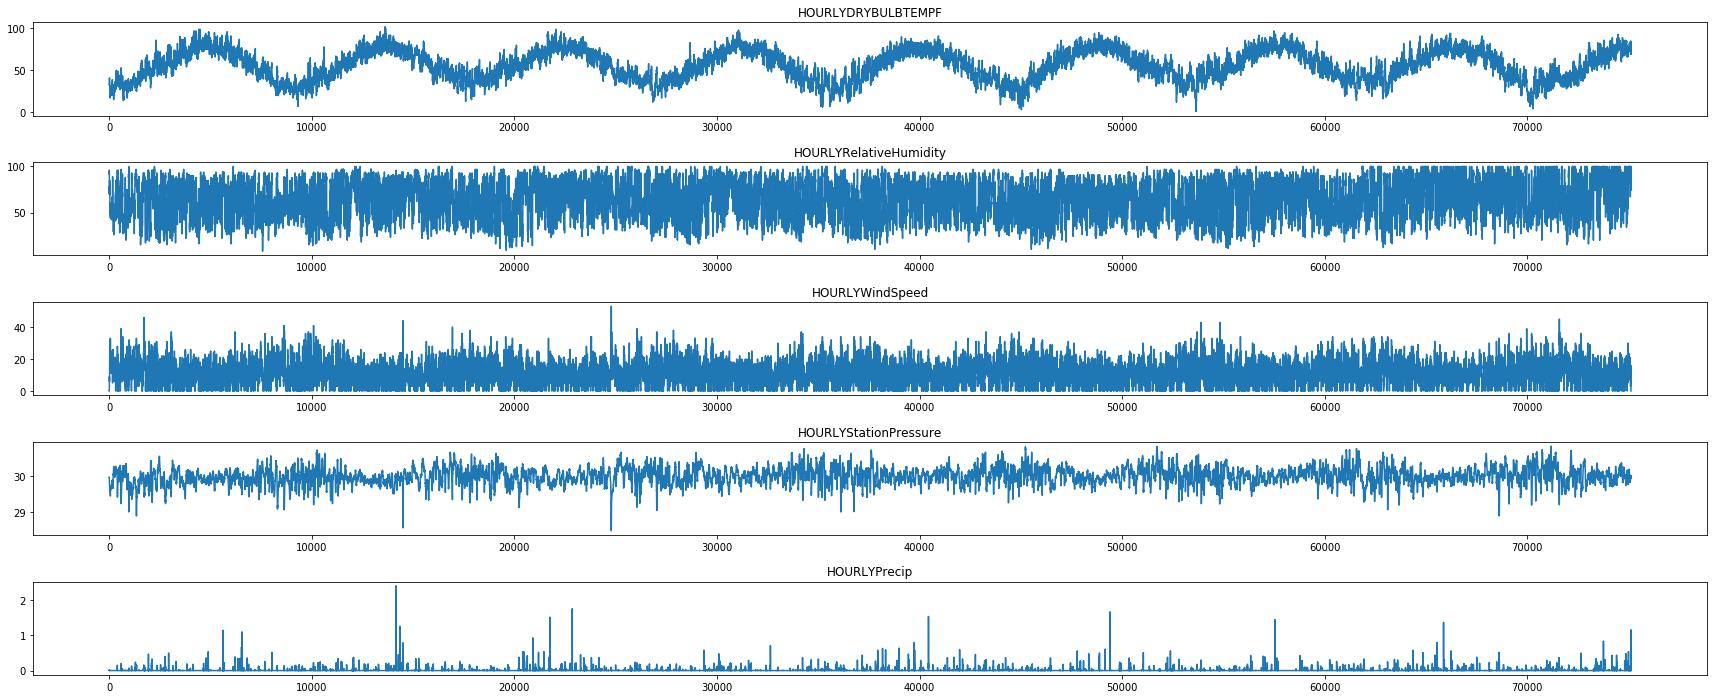

In [12]:
# Columns to visualize
plot_cols = ['HOURLYDRYBULBTEMPF', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed', 'HOURLYStationPressure', 'HOURLYPrecip']
# Quick overview of columns
plt.figure(figsize=(30, 12))
i = 1
for col in plot_cols:
    plt.subplot(len(plot_cols), 1, i)
    plt.plot(cleaned_hourly_data[col].values)
    plt.title(col)
    i += 1
plt.subplots_adjust(hspace=0.5)
plt.show()

As we can see in the plot above, the hourly temperatures follow a clear seasonal trend. Wind speed, pressure, humidity and precipitation data seem to have much higher variance and randomness.

#### Feature Dependencies

Now we explore how the features (columns) of our data are related to each other. This helps in deciding which features to use when modelling a classifier or regresser. 
We ideally want independent features to be classified independently and likewise dependent features to be contributing to the same model. 

We can see from the correlation plots how some features are somewhat correlated and could be used as additional data (perhaps for augmenting) when training a classifier. 

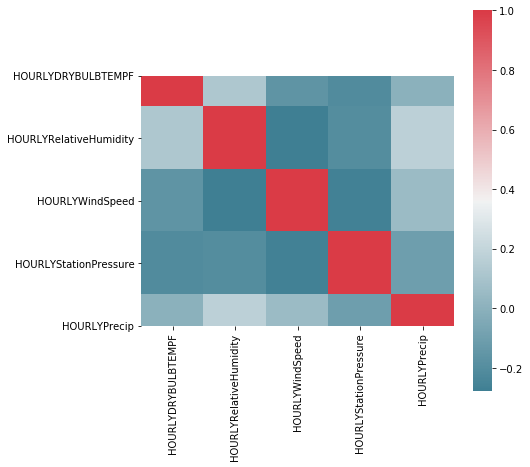

In [13]:
# Plot correlation matrix
f, ax = plt.subplots(figsize=(7, 7))
corr = cleaned_hourly_data[plot_cols].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax);

Additionally we also visualize the joint distrubitions in the form of pairplots/scatter plots to see (qualitatively) the way in which these features are related in more detail over just the correlation. They are essentially 2D joint distributions in the case of off-diagonal subplots and the histogram (an approximation to the probability distribution) in case of the diagonal subplots.

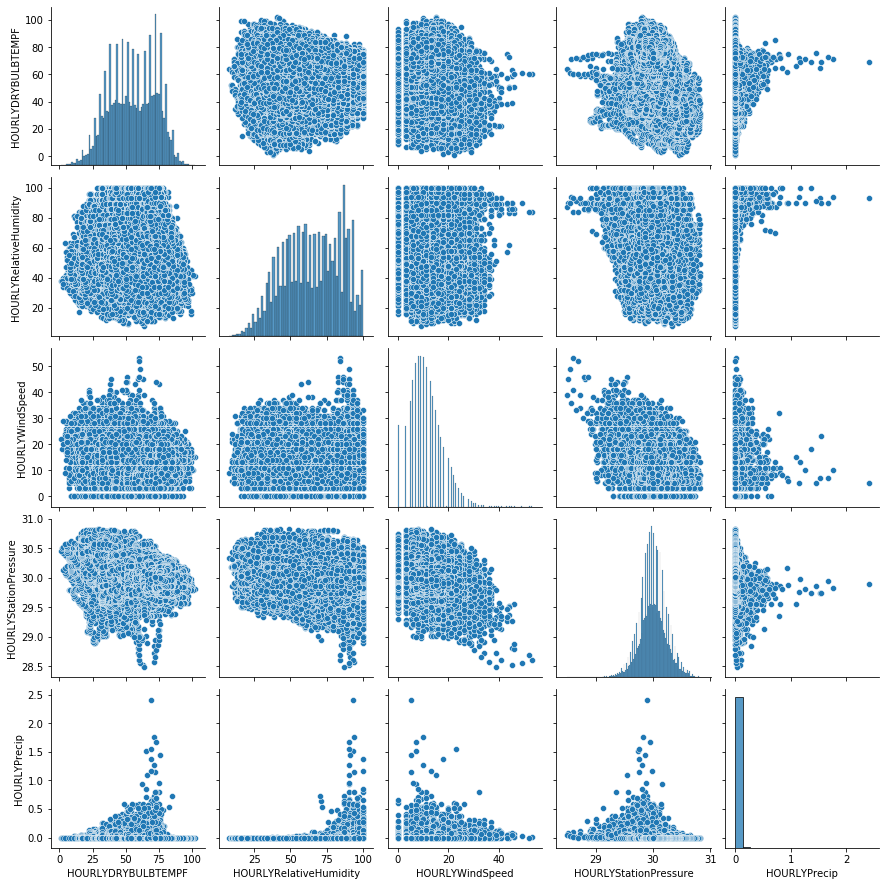

In [14]:
# Plot pairplots
sns.pairplot(cleaned_hourly_data[plot_cols])

### Analyze Trends in the Data

Now that we have explored the whole dataset and the features on a high level, let us focus on one particular feature - `dry_bulb_temp_f`, the dry bulb temperature in degrees Fahrenheit. This is what we mean when we refer to "air temperature". This is the most common feature used in temperature prediction, and here we explore it in further detail. 

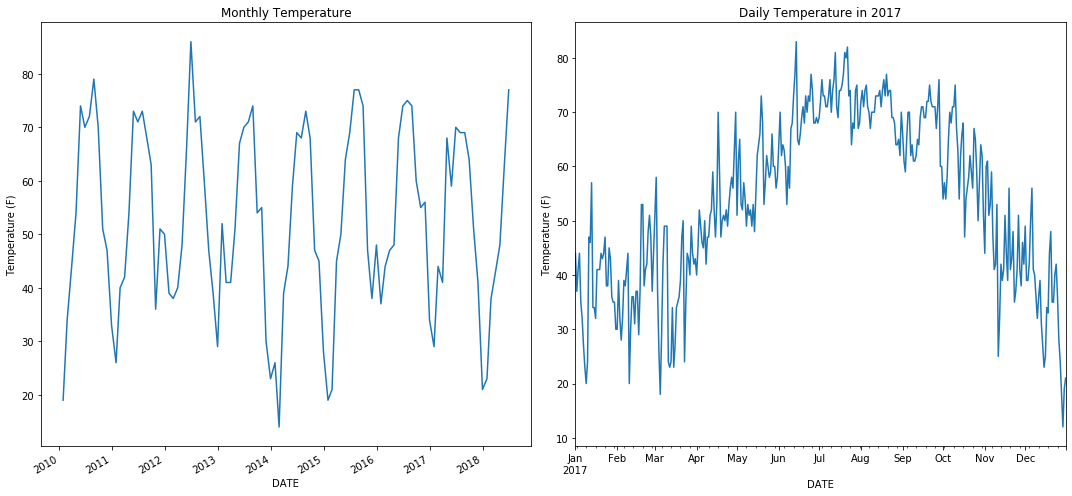

In [15]:
plt.figure(figsize=(15,7))

TEMP_COL = 'HOURLYDRYBULBTEMPF'
# Plot temperature data converted to a monthly frequency 
plt.subplot(1, 2, 1)
cleaned_hourly_data[TEMP_COL].asfreq('M').plot()  
plt.title('Monthly Temperature')
plt.ylabel('Temperature (F)')

# Zoom in on a year and plot temperature data converted to a daily frequency 
plt.subplot(1, 2, 2)
cleaned_hourly_data['2017'][TEMP_COL].asfreq('D').plot()  
plt.title('Daily Temperature in 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

We first start with plotting the data for all 9 years in monthly buckets then drill down to a single year to notice (qualitatively) the overall trend in the data. We can see from the plots that every year has roughly a sinousoidal nature to the temperature with some anomalies around 2013-2014. Upon further drilling down we see that each year's data is not the smooth sinousoid but rather a jagged and noisy one. But the overall trend still is a sinousoid.

Next, we plot the change (delta) in temperature and notice that it is lowest around the middle of the year. That is expected behaviour as the gradient of the sinousoid near it's peak is zero.

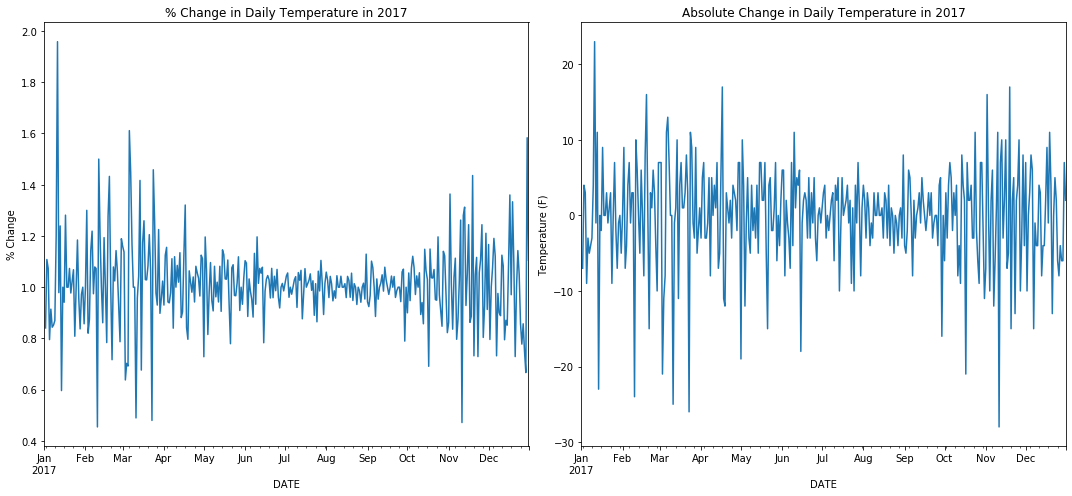

In [16]:
plt.figure(figsize=(15,7))

# Plot percent change of daily temperature in 2017
plt.subplot(1, 2, 1)
cleaned_hourly_data['2017'][TEMP_COL].asfreq('D').div(cleaned_hourly_data['2017'][TEMP_COL].asfreq('D').shift()).plot()
plt.title('% Change in Daily Temperature in 2017')
plt.ylabel('% Change')

# Plot absolute change of temperature in 2017 with daily frequency
plt.subplot(1, 2, 2)
cleaned_hourly_data['2017'][TEMP_COL].asfreq('D').diff().plot()
plt.title('Absolute Change in Daily Temperature in 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

Finally we apply some smoothing to the data in the form of a rolling/moving average. This is the simplest form of de-noising the data. As we can see from the plots, the average (plotted in blue) roughly traces the sinousoid and is now much smoother. This can improve the accuracy of a regression model trained to predict temperatures within a reasonable margin of error.

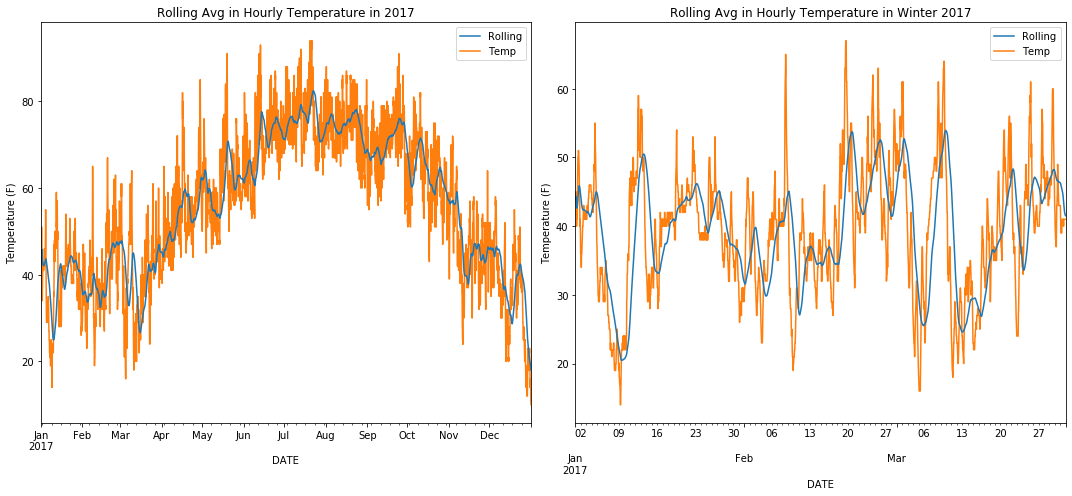

In [17]:
plt.figure(figsize=(15,7))

# Plot rolling mean of temperature 
plt.subplot(1, 2, 1)
cleaned_hourly_data['2017'][TEMP_COL].rolling('5D').mean().plot(zorder=2) # Rolling average window is 5 days
cleaned_hourly_data['2017'][TEMP_COL].plot(zorder=1)
plt.legend(['Rolling','Temp'])
plt.title('Rolling Avg in Hourly Temperature in 2017')
plt.ylabel('Temperature (F)')

# Plot rolling mean of temperature
plt.subplot(1, 2, 2)
cleaned_hourly_data['2017-01':'2017-03'][TEMP_COL].rolling('2D').mean().plot(zorder=2) # Rolling average window is 2 days
cleaned_hourly_data['2017-01':'2017-03'][TEMP_COL].plot(zorder=1)
plt.legend(['Rolling','Temp'])
plt.title('Rolling Avg in Hourly Temperature in Winter 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

# Models for predicting climatological variables

- Temperature
- Humidity
- Precipitation
- Wind Speed

## Steps:

1. Split the dataset into train and test.
2. Tune hyperparameters for the model.
3. Train with the best hyperparameter.
4. Forecast 719 hours of temperature.
5. Save the model.

# Model for Predicting Drybulb Temperature

### 1. Split Data to train and test

In [18]:
# Target Column
Y_COL = 'HOURLYDRYBULBTEMPF'
#
temperature_data = cleaned_hourly_data[[Y_COL]]
#
# Training data
train_endog = temperature_data[:74400]
print('Number of training sample', train_endog.shape)
print('Training Index', train_endog.index)
# Test data 30
test_endog = temperature_data[74400:]
print('Number of testing sample', test_endog.shape)
#test_endog_30 = test_endog_30.asfreq('H')
print('Test-30 Index', test_endog.index)

Number of training sample (74400, 1)
Training Index DatetimeIndex(['2010-01-01 01:00:00', '2010-01-01 02:00:00',
               '2010-01-01 03:00:00', '2010-01-01 04:00:00',
               '2010-01-01 05:00:00', '2010-01-01 06:00:00',
               '2010-01-01 07:00:00', '2010-01-01 08:00:00',
               '2010-01-01 09:00:00', '2010-01-01 10:00:00',
               ...
               '2018-06-27 15:00:00', '2018-06-27 16:00:00',
               '2018-06-27 17:00:00', '2018-06-27 18:00:00',
               '2018-06-27 19:00:00', '2018-06-27 20:00:00',
               '2018-06-27 21:00:00', '2018-06-27 22:00:00',
               '2018-06-27 23:00:00', '2018-06-28 00:00:00'],
              dtype='datetime64[ns]', name='DATE', length=74400, freq='60T')
Number of testing sample (719, 1)
Test-30 Index DatetimeIndex(['2018-06-28 01:00:00', '2018-06-28 02:00:00',
               '2018-06-28 03:00:00', '2018-06-28 04:00:00',
               '2018-06-28 05:00:00', '2018-06-28 06:00:00',
          

### 2. Tune hyperparameters for the model

##### Uncomment the below cell to run the hyperparameter tuning. 

We ran the tuning before and the best parameter in the range (0, 4) is (3, 1, 2)

In [19]:
# NOTE - Do not run this cell if running hyperparameter tuning
best_param = (3,1,2)

### 3. Train with the best hyperparameter

In [20]:
# Fitting model with the best parameter
model_ar1 = SARIMAX(train_endog, order=best_param)
results_ar1 = model_ar1.fit()
print('Parameter {}- {}'.format(best_param,results_ar1.aic))

Parameter (3, 1, 2)- 269337.0135592872


### 4. Save the model

In [22]:
temp_model_path = 'noaa-weather-data-jfk-airport/arima_temp_model.json'
# Save the model as json
results_ar1.save(temp_model_path)

### 5. Forecast 719 hours of temperature (1 step predict 5 hours)

In [23]:
loaded_temp_model = ARIMAResults.load(temp_model_path)
forecast = []
forecast_period = []

for i in range(0, len(test_endog), 5):
    result = loaded_temp_model.forecast(steps=5)
    for j in range(len(result)):
        forecast.append(result[j])
        forecast_period.append(str(result.index[j]))
    loaded_temp_model = loaded_temp_model.extend(test_endog[i:i+5])

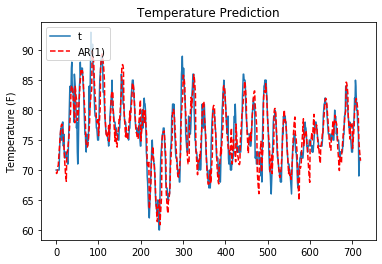

In [24]:
# plot actual vs predicted values 
plt.plot(np.asarray(test_endog))
plt.plot(np.asarray(forecast), color='r', linestyle='--')
plt.legend(['t', 'AR(1)'], loc=2)
plt.title('Temperature Prediction')
plt.ylabel('Temperature (F)')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [25]:
# rmse calculation
np.sqrt(mean_squared_error(test_endog, forecast[0:719]))

2.7142473780808523